In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Read all the data

In [2]:
work_path = os.path.abspath(os.path.dirname(os.getcwd()))

In [14]:
price_dji = pd.read_csv(work_path+"/Data/Dow Jones Industrial Average Historical Data - Daily.csv")[["Date", "Price"]]
price_hs = pd.read_csv(work_path+"/Data/Hang Seng Historical Data - Daily.csv")[["Date", "Price"]]
price_sp500 = pd.read_csv(work_path+"/Data/S&P 500 Historical Data - Daily.csv")[["Date", "Price"]]
price_sh = pd.read_csv(work_path+"/Data/Shanghai Composite Historical Data - Daily.csv")[["Date", "Price"]]
price_szse = pd.read_csv(work_path+"/Data/SZSE Component Historical Data - Daily.csv")[["Date", "Price"]]

In [4]:
class data_maker():
    def __init__(self, data, task) -> None:
        self.data = data.astype("float")
        self.task = task
        self.data_diff = np.diff(data)
        self.data_return = np.diff(data)/data[:-1]

    def create_sliding_windows(self, data_type, window_size, stride):
        if data_type == "origin":
            data = self.data
        if data_type=="return":
            data = self.data_return
        if data_type=="diff":
             data = self.data_diff
        num_samples = len(data)
        num_windows = ((num_samples - window_size) // stride) + 1
        X_matrix = np.zeros((num_windows, window_size))

        for i in range(num_windows):
            start = i * stride
            end = start + window_size
            window = data[start:end]
            X_matrix[i, :] = window.T

        return X_matrix
    
    def classifiction_pm(self, data_type, window_size, stride, test_size):
        if data_type == "origin":
            data = self.data
        if data_type=="return":
            data = self.data_return
        if data_type=="diff":
             data = self.data_diff
        num_samples = len(data)
        num_windows = ((num_samples - window_size) // stride) + 1
        X_matrix_m = []
        X_matrix_p = []
        if data_type == "origin":
            for i in range(num_windows-1):
                start = i * stride
                end = start + window_size
                window = data[start:end]
                if data[end] >= window[-1]:
                    X_matrix_p.append(window.T)
                else:
                    X_matrix_m.append(window.T)
        else:
            for i in range(num_windows-1):
                start = i * stride
                end = start + window_size
                window = data[start:end]
                if data[end] >= 0:
                    X_matrix_p.append(window.T)
                else:
                    X_matrix_m.append(window.T)

        return np.array(X_matrix_p[:-test_size]), np.array(X_matrix_p[-test_size:]), np.array(X_matrix_m[:-test_size]), np.array(X_matrix_m[-test_size:])

In [5]:
class KSVD():
    def __init__(self, time_series, K=256, K0=None):
        self.D = None
        self.K = K
        self.K0 = K0
        self.time_series = time_series.T
        self.num = time_series.shape[0]
        self.length = time_series.shape[1]
    
    def initialize(self):

        shape=[self.length, self.K]
        self.D = np.ones(shape)
        for i in range(shape[1]):
            self.D[:, i]=self.D[:, i]/np.linalg.norm(self.D[:, i])

    def update_dict(self, sparse_code):
        for i in range(self.K):
            index = np.nonzero(sparse_code[i, :])[0]
            if len(index) == 0:
                continue
            self.D[:, i] = 0
            r = (self.time_series - np.dot(self.D, sparse_code))[:, index]
            u, s, v = np.linalg.svd(r, full_matrices=False)
            self.D[:, i] = u[:, 0].T
            sparse_code[i, index] = s[0] * v[0, :]
        return self.D, sparse_code
    
    def projection(self, z):
        res = z.copy()
        sort = np.sort(res, axis=0)[-self.K0, :]
        res = np.where(res - sort[np.newaxis, :]>=0, res, 0)
        return res
    
    def projection_test(self, z, threshold):
        res = z.copy()
        res = np.where(res>threshold, res, 0)
        return res

    def sparse_coding(self, tol, max_iter, time_series=None, projection_type="train"):
        if time_series is None:
            time_series = self.time_series
            projection_type = "train"
        L = np.sort(np.linalg.eigvalsh(np.matmul(self.D.T, self.D)))[-1]
        step_size = 1 / L
        sparse_code = np.zeros((self.K, time_series.shape[1]))
        sparse_code_next = sparse_code
        sparse_code_change = 1
        count = 0
        while sparse_code_change > tol and count < max_iter:
            sparse_code = sparse_code_next
            count += 1
            sparse_code_next = sparse_code - step_size * np.matmul(self.D.T, np.matmul(self.D, sparse_code) - time_series)
            if projection_type == "train":
                sparse_code_next = self.projection(sparse_code_next)
            if projection_type == "test":
                sparse_code_next = self.projection_test(sparse_code_next, 0.001)
            sparse_code_change = np.max(np.abs(sparse_code_next - sparse_code))
        return sparse_code_next
    
    def ksvd(self, max_iter):
        self.initialize()
        sparse_code = self.sparse_coding(1e-5, 1000)
        for i in range(max_iter):
            dictionary, sparse_code = self.update_dict(sparse_code)
            sparse_code = self.sparse_coding(1e-5, 1000)
        return dictionary, sparse_code

In [6]:
test_size = 100
window_size = 50
stride = 1

In [15]:
def preprocess(price):
    price = price.copy()
    price.columns = price.columns.map(lambda x: x.lower())
    price.loc[:, "price"] = price["price"].map(lambda x: x.replace(",", ""))
    price.loc[:, "price"] = price["price"].astype("float")
    time_series = np.array(price["price"])
    return time_series

In [19]:
def test_reconstruction(price, name):

    time_series = preprocess(price)
    model_data = data_maker(time_series, "classification_pm")
    X_re_p, X_test_p, X_re_m, X_test_m = model_data.classifiction_pm("return", window_size, stride, test_size)

    model_m = KSVD(X_re_m.astype("float"), K=150, K0=15)
    _, code_m = model_m.ksvd(100)
    test_m_code_sp = model_m.sparse_coding(1e-7, 1000, time_series=X_test_m.astype("float").T, projection_type="train")
    test_m_code_spt = model_m.sparse_coding(1e-7, 1000, time_series=X_test_m.astype("float").T, projection_type="test")
    test_m_code = model_m.sparse_coding(1e-7, 1000, time_series=X_test_m.astype("float").T, projection_type=None)

    recon_m_sp = model_m.D.dot(test_m_code_sp)
    recon_m_spt = model_m.D.dot(test_m_code_spt)
    recon_m = model_m.D.dot(test_m_code)

    plt.plot(X_test_m[1], label="origin")
    plt.plot(recon_m_sp[:,1], label="sparse-code1")
    plt.plot(recon_m[:,1], label="full-code")
    plt.plot(recon_m_spt[:,1], label="sparse-code2")
    plt.xlabel("time")
    plt.ylabel("return")
    plt.legend()
    plt.title(f"Reconstruction for the {name} in the test set")
    plt.show()
    # plt.savefig("/Users/shurui/python/sparseDictionaryTimeSeries/recons.jpg")

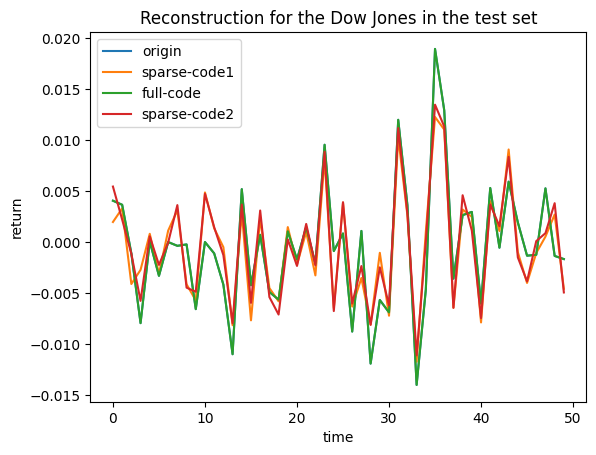

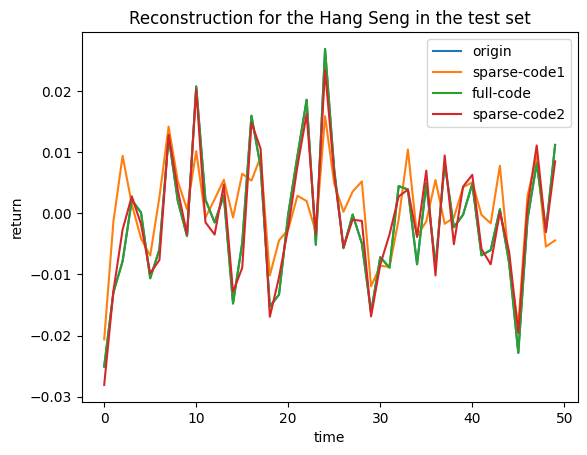

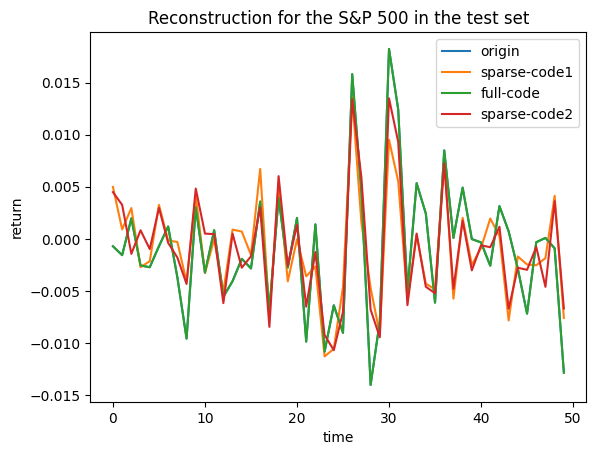

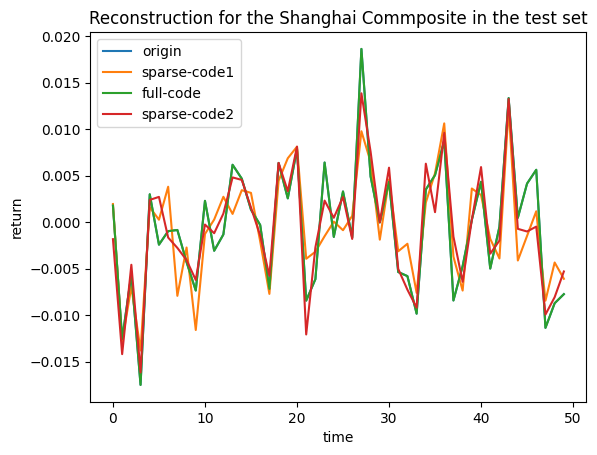

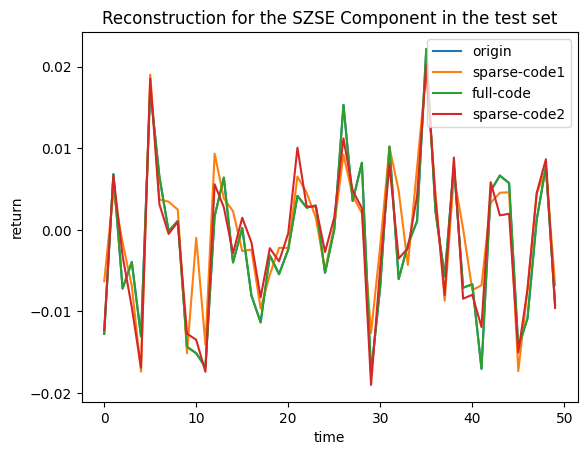

In [20]:
test_reconstruction(price_dji, "Dow Jones")
test_reconstruction(price_hs, "Hang Seng")
test_reconstruction(price_sp500, "S&P 500")
test_reconstruction(price_sh, "Shanghai Commposite")
test_reconstruction(price_szse, "SZSE Component")

In [28]:
def test_updown_classification(price, name):
    
    time_series = preprocess(price)
    model_data = data_maker(time_series, "classification_pm")
    X_re_p, X_test_p, X_re_m, X_test_m = model_data.classifiction_pm("return", window_size, stride, test_size)

    model_m = KSVD(X_re_m.astype("float"), K=150, K0=15)
    _, code_m = model_m.ksvd(100)

    model_p = KSVD(X_re_p.astype("float"), K=150, K0=15)
    _, code_p = model_p.ksvd(100)

    test_m_code = model_m.sparse_coding(1e-7, 1000, time_series=X_test_m.astype("float").T, projection_type=None)
    test_p_code = model_p.sparse_coding(1e-7, 1000, time_series=X_test_p.astype("float").T, projection_type=None)
    test_m_code_p = model_p.sparse_coding(1e-7, 1000, time_series=X_test_m.astype("float").T, projection_type=None)
    test_p_code_m= model_m.sparse_coding(1e-7, 1000, time_series=X_test_p.astype("float").T, projection_type=None)

    resm = np.sum(np.abs(test_m_code_p), axis=0) - np.sum(np.abs(test_m_code), axis=0)
    resp = np.sum(np.abs(test_p_code_m), axis=0) - np.sum(np.abs(test_p_code), axis=0)
    accuracy = (np.where(resm>0, 1, 0).sum() + np.where(resp>0, 1, 0).sum()) / (2*test_size)
    print(f"The accuracy score for the method 1 on the {name} test set is {accuracy}\n")

    test_m_code = model_m.sparse_coding(1e-7, 1000, time_series=X_test_m.astype("float").T, projection_type="test")
    test_p_code = model_p.sparse_coding(1e-7, 1000, time_series=X_test_p.astype("float").T, projection_type="test")
    test_m_code_p = model_p.sparse_coding(1e-7, 1000, time_series=X_test_m.astype("float").T, projection_type="test")
    test_p_code_m= model_m.sparse_coding(1e-7, 1000, time_series=X_test_p.astype("float").T, projection_type="test")

    resm = np.count_nonzero(test_m_code_p, axis=0)-np.count_nonzero(test_m_code, axis=0)
    resp = np.count_nonzero(test_p_code_m, axis=0)-np.count_nonzero(test_p_code, axis=0)
    accuracy = (np.where(resm>0, 1, 0).sum() + np.where(resp>0, 1, 0).sum()) / (2*test_size)
    print(f"The accuracy score for the method 2 on the {name} test set is {accuracy}\n")

    return

In [29]:
test_updown_classification(price_dji, "Dow Jones")
test_updown_classification(price_hs, "Hang Seng")
test_updown_classification(price_sp500, "S&P 500")
test_updown_classification(price_sh, "Shanghai Commposite")
test_updown_classification(price_szse, "SZSE Component")

The accuracy score for the method 1 on the Dow Jones test set is 0.59

The accuracy score for the method 2 on the Dow Jones test set is 0.455

The accuracy score for the method 1 on the Hang Seng test set is 0.52

The accuracy score for the method 2 on the Hang Seng test set is 0.435

The accuracy score for the method 1 on the S&P 500 test set is 0.52

The accuracy score for the method 2 on the S&P 500 test set is 0.44

The accuracy score for the method 1 on the Shanghai Commposite test set is 0.51

The accuracy score for the method 2 on the Shanghai Commposite test set is 0.475

The accuracy score for the method 1 on the SZSE Component test set is 0.48

The accuracy score for the method 2 on the SZSE Component test set is 0.415

